# Fraud-Detection-Imbalanced-Dataset

## Introductiton

This project demonstrates advanced techniques for handling imbalanced datasets in the context of credit card fraud detection. As an MSc in Computer Science graduate with a focus on machine learning, I've implemented and analyzed various methods to address the inherent class imbalance problem often encountered in real-world fraud detection scenarios.

The notebook is structured as follows:

0. **Preparation**: Initial setup and library imports.

1. **Data Preprocessing and Exploration**: Detailed analysis of the Kaggle Credit Card Fraud dataset, including feature descriptions and initial data handling steps.

2. **Addressing Class Imbalance**: Implementation and evaluation of multiple techniques to handle the imbalanced nature of the dataset, including oversampling, undersampling, and synthetic data generation methods.

3. **Comparative Analysis**: A comparison of the different approaches, assessing their impact on model performance and discussing the trade-offs involved.


## 0. Preparation

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn import metrics



## 1. Data Preprocessing and Exploration

The Kaggle Credit Card Fraud dataset is used for this analysis. Key features include:

- V1 to V28: Principal components obtained with PCA
- Time: Seconds elapsed since the first transaction
- Amount: Transaction amount
- Class: Response variable (1 for fraud, 0 otherwise)

The dataset is highly imbalanced, with fraudulent transactions being rare. 'Time' and 'Amount' are the only features not transformed by PCA.

Preprocessing steps include data loading, handling any missing values, and scaling 'Time' and 'Amount' features to align with the PCA-transformed features.

This concise overview provides the necessary context without adding excessive details.

In [74]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.1 Examining the class Imbalance

In [75]:
raw_df.shape

(284807, 31)

In [78]:
raw_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

### 1.2 Feature Engineering

In [79]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

### 1.3 Train Test Split

In [80]:
X = cleaned_df.drop(columns=['Class'])
y = cleaned_df['Class']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of the development features: " + str(X_dev.shape))
print("Shape of the test features: " + str(X_test.shape))

Shape of the development features: (227845, 29)
Shape of the test features: (56962, 29)


### 1.4 Feature Normalization

In [81]:
scaler = StandardScaler()
X_dev = scaler.fit_transform(X_dev)
X_test = scaler.transform(X_test)

## 2. Addressing Class Imbalance


### 2.1 Baseline Model (No Resampling)

In [87]:
dtc = DecisionTreeClassifier(max_depth=10, random_state=42)
model_default = dtc.fit(X_dev, y_dev)
scores = cross_validate(dtc, X_dev, y_dev, cv=5, scoring = ['roc_auc', 'average_precision'])
print('ROC values:')
print(scores['test_roc_auc'])
print('Average Precision values:')
print(scores['test_average_precision'])

ROC values:
[0.86957634 0.82799822 0.83798122 0.88266235 0.90893353]
Average Precision values:
[0.64646286 0.6763446  0.61677062 0.68317716 0.68281098]


### 2.2 Oversampling

Oversampling increases the number of instances in the minority class by duplicating or creating new synthetic examples. This technique balances the class distribution by increasing the representation of the minority class. While it can help improve model sensitivity to the minority class, it may lead to overfitting if not carefully implemented.


In [83]:
ros = RandomOverSampler(random_state=42)
X_dev_oversample, y_dev_oversample = ros.fit_resample(X_dev, y_dev)
y_dev_oversample.value_counts()

0    227451
1    227451
Name: Class, dtype: int64

In [84]:
print('X_dev_oversample shape:')
print(X_dev_oversample.shape)
print('y_dev_oversample shape:')
print(y_dev_oversample.shape)

X_dev_oversample shape:
(454902, 29)
y_dev_oversample shape:
(454902,)


In [85]:
dtc = DecisionTreeClassifier(max_depth=10, random_state=42)
model_oversample = dtc.fit(X_dev_oversample, y_dev_oversample)
scores = cross_validate(dtc, X_dev_oversample, y_dev_oversample, cv=5, scoring = ['roc_auc', 'average_precision'])
print('ROC values (oversample):')
print(scores['test_roc_auc'])
print('Average Precision values(oversample):')
print(scores['test_average_precision'])

ROC values (oversample):
[0.99840012 0.9983086  0.99847279 0.99847804 0.99857557]
Average Precision values(oversample):
[0.99786268 0.99767719 0.9978636  0.99787444 0.99807898]


### 2.3 Undersampling

Undersampling reduces the number of instances in the majority class to match the minority class. This technique balances the dataset by removing instances from the overrepresented class. While effective in reducing class imbalance, it can potentially discard useful information from the majority class.

In [88]:
rus = RandomUnderSampler(random_state=42, replacement=False)
X_dev_subsample, y_dev_subsample = rus.fit_resample(X_dev, y_dev)
y_dev_subsample.value_counts()

0    394
1    394
Name: Class, dtype: int64

In [90]:
dtc = DecisionTreeClassifier(max_depth=10, random_state=42)
model_subsample = dtc.fit(X_dev_subsample, y_dev_subsample)
scores = cross_validate(dtc, X_dev_subsample, y_dev_subsample, cv=5, scoring = ['roc_auc', 'average_precision'])
print('ROC values (undersample):')
print(scores['test_roc_auc'])
print('Average Precision values(undersample):')
print(scores['test_average_precision'])

ROC values (undersample):
[0.8852748  0.86388399 0.89873418 0.91731581 0.94790652]
Average Precision values(undersample):
[0.82838644 0.81661392 0.86683544 0.87531025 0.92073059]


### 2.4 SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic examples in the minority class by interpolating between existing minority instances. This technique increases the minority class size without simple duplication, potentially reducing the risk of overfitting associated with random oversampling. SMOTE can be particularly effective when the minority class lacks diversity.

In [91]:
smote = SMOTE(random_state=42)
X_dev_smote, y_dev_smote = smote.fit_resample(X_dev, y_dev)
y_dev_smote.value_counts()

0    227451
1    227451
Name: Class, dtype: int64

In [93]:
dtc= DecisionTreeClassifier(max_depth=10, random_state=42)
model_smote= dtc.fit(X_dev_smote, y_dev_smote)
scores = cross_validate(dtc, X_dev_smote, y_dev_smote, cv=5, scoring = ['roc_auc', 'average_precision'])
print('ROC values (smote):')
print(scores['test_roc_auc'])
print('Average Precision values (smote):')
print(scores['test_average_precision'])

ROC values (smote):
[0.99729603 0.99747394 0.99713467 0.99703584 0.99724342]
Average Precision values (smote):
[0.99658165 0.99656764 0.99603047 0.99593317 0.99618909]


## 3. Comparative Analysis

### 3.1 AUC Scores

In [94]:
auc_default = metrics.roc_auc_score(y_test, model_default.predict_proba(X_test)[:, 1])
auc_oversample = metrics.roc_auc_score(y_test, model_oversample.predict_proba(X_test)[:, 1])
auc_undersample = metrics.roc_auc_score(y_test, model_subsample.predict_proba(X_test)[:, 1])
auc_smote = metrics.roc_auc_score(y_test, model_smote.predict_proba(X_test)[:, 1])

print(f'{auc_default=}')
print(f'{auc_oversample=}')
print(f'{auc_undersample=}')
print(f'{auc_smote=}')

auc_default=0.871912253224306
auc_oversample=0.8609190528349776
auc_undersample=0.9050787485787788
auc_smote=0.8893473364303515


### 3.2 Confusion Matrix

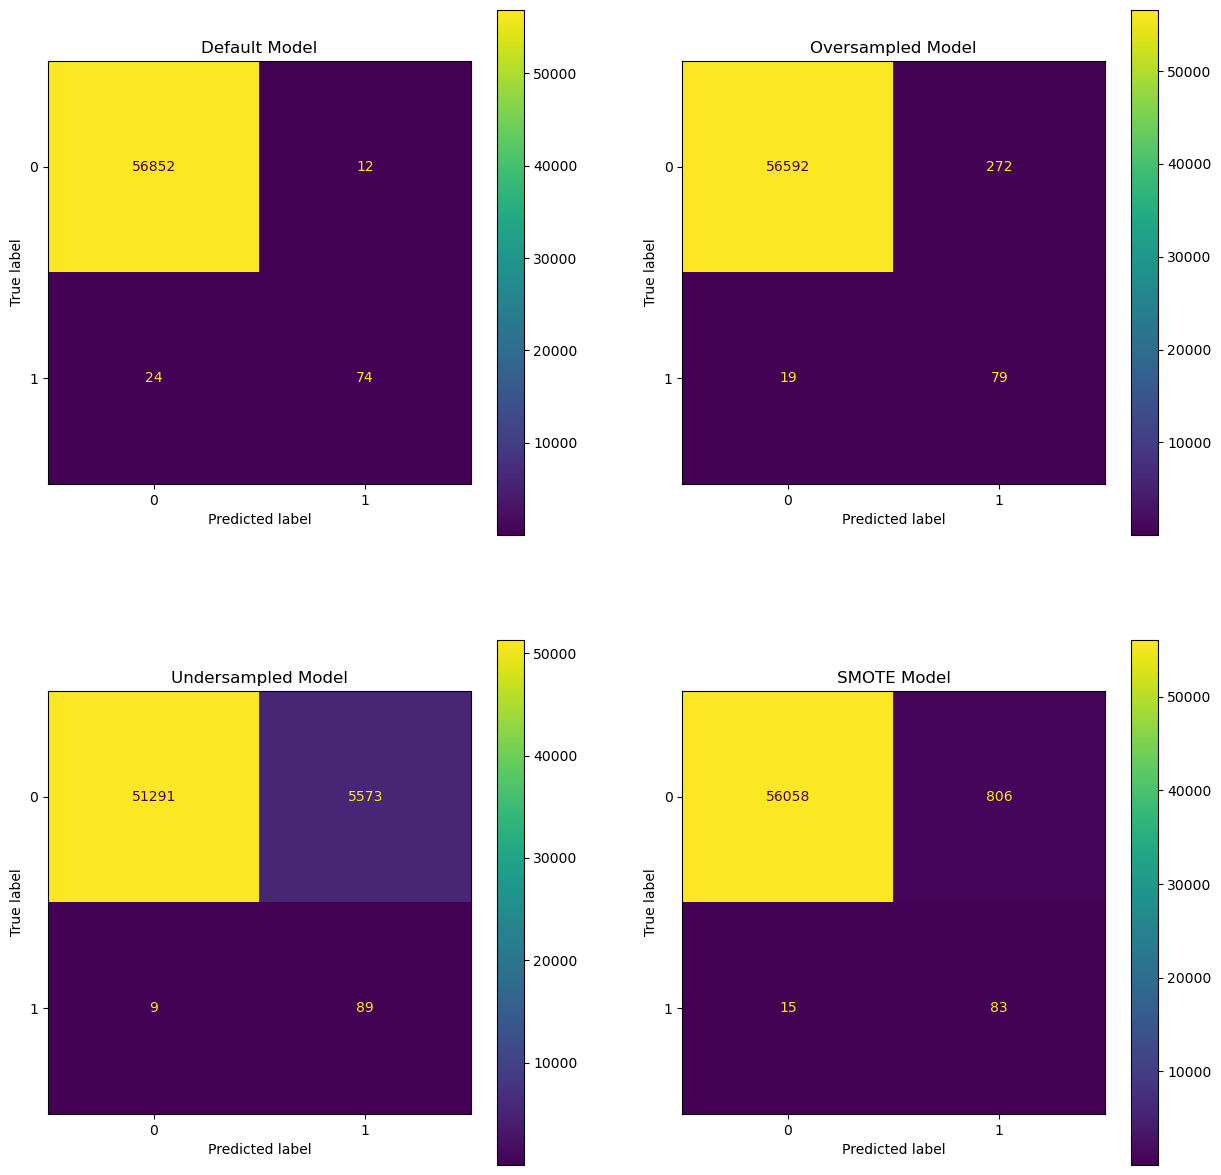

In [95]:
fig, ax = plt.subplots(2,2,figsize=(15,15))
metrics.plot_confusion_matrix(model_default, X_test, y_test, ax=ax[0][0])
metrics.plot_confusion_matrix(model_oversample, X_test, y_test, ax=ax[0][1])
metrics.plot_confusion_matrix(model_subsample, X_test, y_test, ax=ax[1][0])
metrics.plot_confusion_matrix(model_smote, X_test, y_test, ax=ax[1][1])
ax[0][0].set_title('Default Model')
ax[0][1].set_title('Oversampled Model')
ax[1][0].set_title('Undersampled Model')
ax[1][1].set_title('SMOTE Model')
plt.show()

- The Undersampled Model shows the highest False Positive rate and the lowest False Negative rate, indicating a bias towards the positive class.
- In contrast, the Default Model exhibits the highest False Negative rate and the lowest False Positive rate, suggesting a conservative approach to positive predictions.
- Both the Oversampled and SMOTE Models demonstrate higher False Positive rates compared to the Default Model, though not as high as the Undersampled Model.
- For fraud detection scenarios, where False Positives (incorrectly flagging legitimate transactions as fraudulent) can be more costly in terms of customer experience and operational overhead, the Default Model may be preferable despite its higher False Negative rate.
- However, the choice of model should ultimately depend on the specific cost-benefit analysis of False Positives versus False Negatives in the given application context.

### 3.3 AUC Plot

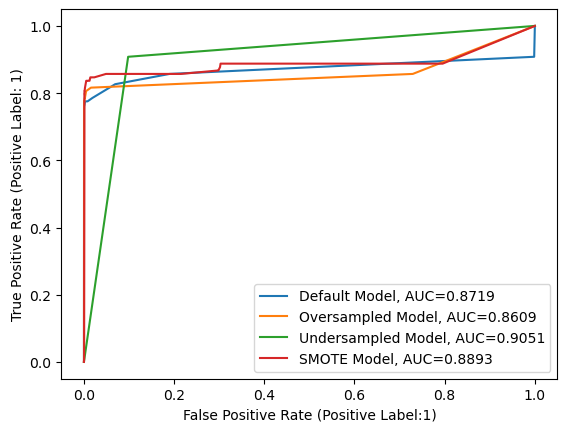

In [96]:
#Reference: https://www.statology.org/plot-multiple-roc-curves-python/

auc_default = round(metrics.roc_auc_score(y_test, model_default.predict_proba(X_test)[:, 1]),4)
auc_oversample = round(metrics.roc_auc_score(y_test, model_oversample.predict_proba(X_test)[:, 1]),4)
auc_undersample = round(metrics.roc_auc_score(y_test, model_subsample.predict_proba(X_test)[:, 1]),4)
auc_smote = round(metrics.roc_auc_score(y_test, model_smote.predict_proba(X_test)[:, 1]),4)

fpr, tpr, _ = metrics.roc_curve(y_test, model_default.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr,label="Default Model, AUC="+str(auc_default))

fpr, tpr, _ = metrics.roc_curve(y_test, model_oversample.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr,label="Oversampled Model, AUC="+str(auc_oversample))

fpr, tpr, _ = metrics.roc_curve(y_test, model_subsample.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr,label="Undersampled Model, AUC="+str(auc_undersample))

fpr, tpr, _ = metrics.roc_curve(y_test, model_smote.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr,label="SMOTE Model, AUC="+str(auc_smote),)

plt.legend()
plt.xlabel('False Positive Rate (Positive Label:1)')
plt.ylabel('True Positive Rate (Positive Label: 1)')
plt.show()


The Undersampled Model exhibits the highest AUC value, indicating better overall performance across different classification thresholds. However, there's a notable trade-off in its behavior:

- Lower TPR region (TPR < 0.8): 
  The Undersampled Model shows a higher False Positive Rate (FPR) compared to other models.
- Higher TPR region (TPR > 0.8):
   The Undersampled Model generally outperforms the others.

### 3.4 Balancd Decision Tree and Confusion Matrix

Class Weighting (Algorithm-level method) adjusts the importance of each class during model training by assigning higher weights to the minority class. This technique, often implemented through the 'balanced' parameter in sklearn, modifies the learning algorithm to pay more attention to the underrepresented class without changing the original dataset. It's computationally efficient and preserves the original data distribution.

In [97]:
dtc_balanced = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')
model_balanced= dtc_balanced.fit(X_dev, y_dev)
auc_balanced = metrics.roc_auc_score(y_test, model_balanced.predict_proba(X_test)[:, 1])
ap_balanced = metrics.average_precision_score(y_test, model_balanced.predict_proba(X_test)[:, 1])
print(f'{auc_balanced=}')
print(f'{ap_balanced=}')

auc_balanced=0.8432507780827582
ap_balanced=0.5875834789285715


<!-- **1.3.12 Train a balanced Decision tree classifier. (You can use max_depth=10 and random_state=42)( balance the class weights). Print the AUC and average precision on test set** (Use Random state = 42) -->

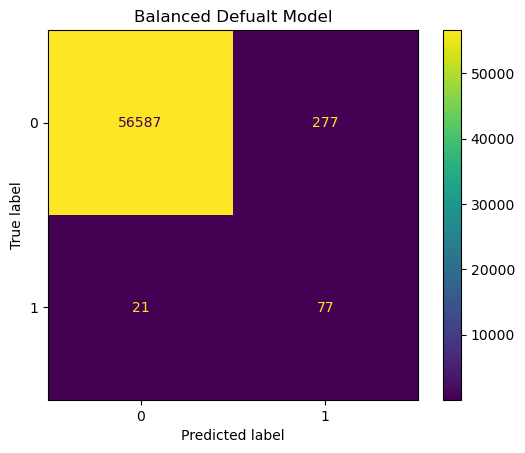

In [99]:
metrics.plot_confusion_matrix(model_balanced, X_test, y_test)
plt.title('Balanced Defualt Model')
plt.show()

Overall, the Balanced Model has a pretty good performance, which is similar to Oversampled Model. But still, it has a slightly higher False Positive Rate than the default model. 